In [23]:
import torch
from torch.nn import functional as F
from torch import nn
import os
from torch.utils.data import Dataset, DataLoader
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms
from pathlib import Path
import random
from PIL import Image
import seaborn as sns
import pandas as pd
from torchinfo import summary
from torchvision import models
from torch.optim import lr_scheduler

dog


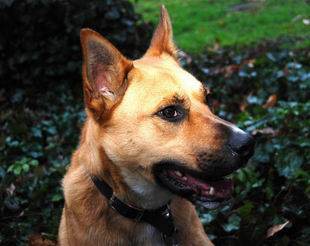

In [3]:
image_path = Path('data/cat_dog')
imagelist = list(image_path.glob('*/*/*.jpg'))
random_image_path = random.choice(imagelist)
print(random_image_path.stem[:3])
Image.open(random_image_path)

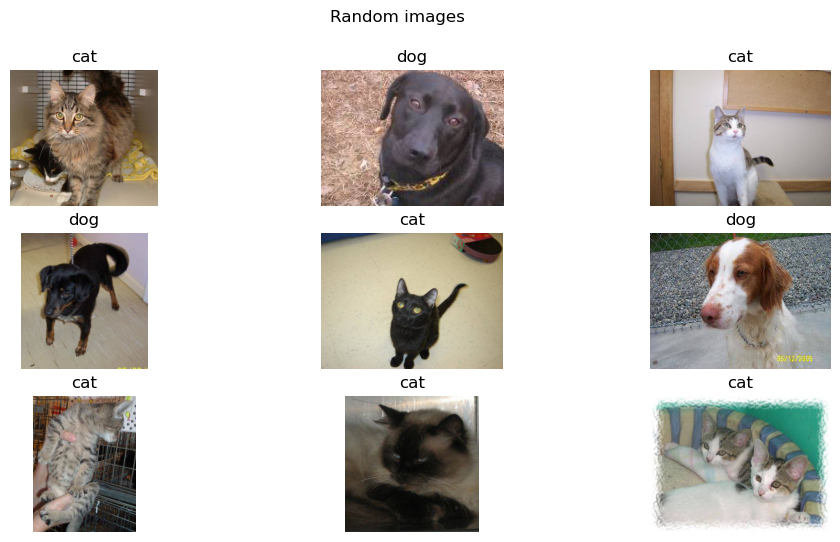

In [4]:
n_rows = 3
n_cols = 3
fig = plt.figure(figsize=(12, 6))

for i in range(1, n_rows*n_cols+1):
    rand_img_path = random.choice(imagelist)
    fig.add_subplot(n_rows, n_cols, i)
    plt.imshow(plt.imread(rand_img_path))
    plt.title(rand_img_path.stem[:3])
    plt.axis(False)
    plt.suptitle('Random images')

plt.show()

In [13]:
dim1_mean, dim2_mean = (360, 404)
dim1_mean, dim2_mean

(360, 404)

In [14]:
dim1_mean, dim2_mean = dim1_mean//8, dim2_mean//8

cus_transfrom = transforms.Compose([
    transforms.Resize(size=[dim1_mean, dim2_mean]),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

torch.Size([3, 45, 50])


(-0.5, 49.5, 44.5, -0.5)

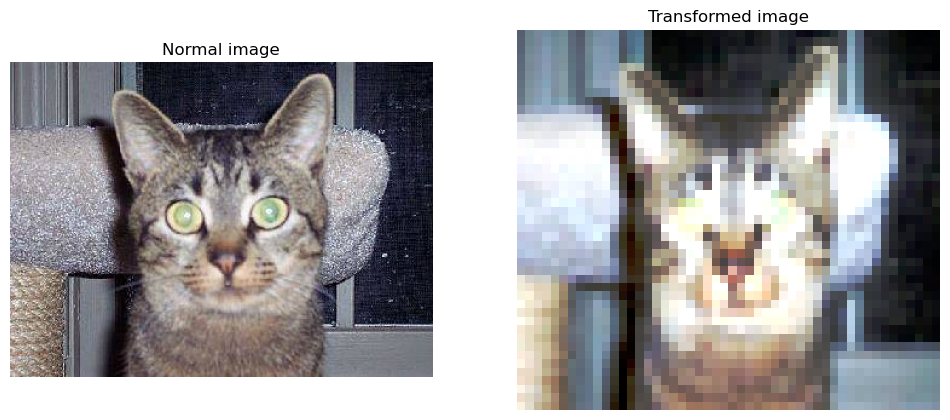

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
image = imagelist[random.randint(0, len(imagelist))]
transformed_image = cus_transfrom(Image.open(image))
print(transformed_image.shape)
ax[0].imshow(plt.imread(image))
ax[0].set_title('Normal image')
ax[0].axis(False)
ax[1].imshow(transformed_image.permute(1,2,0))
ax[1].set_title('Transformed image')
ax[1].axis(False)

In [16]:
trainpath = Path('data/cat_dog/train/')
testpath = Path('data/cat_dog/test/')

def get_classes(path: Path):
    classes = [folder.name for folder in os.scandir(path) if folder.is_dir()]
    classes_to_idx = {k:v for v, k in enumerate(classes)}
    return classes, classes_to_idx
get_classes(trainpath)

(['cat', 'dog'], {'cat': 0, 'dog': 1})

In [17]:
class ImageDataset(Dataset):
    def __init__(self, target_dir: str, transform: torchvision.transforms = None):
        super().__init__()
        self.paths = list(Path(target_dir).glob('*/*.jpg'))
        self.transform = transform
        self.classes, self.classes_to_idx = get_classes(target_dir)

    def load_image(self, idx):
        return Image.open(self.paths[idx])

    def __getitem__(self, idx):
        img = self.load_image(idx)
        class_name = self.paths[idx].parent.name
        class_idx = self.classes_to_idx[class_name]
        if self.transform:
            img = self.transform(img)
        return img, class_idx

    def __len__(self):
        return len(self.paths)

In [38]:
train_transforms = transforms.Compose([
    transforms.Resize(size=[64, 64]),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])
test_transforms = transforms.Compose([
    transforms.Resize(size=[64, 64]),
    transforms.ToTensor()
])

In [39]:
train_dataset = ImageDataset(trainpath, transform=train_transforms)
test_dataset = ImageDataset(testpath, transform=test_transforms)

len(train_dataset), len(test_dataset)

(20000, 5000)

torch.Size([3, 64, 64])


(<matplotlib.image.AxesImage at 0x1c5f53f46a0>, 0)

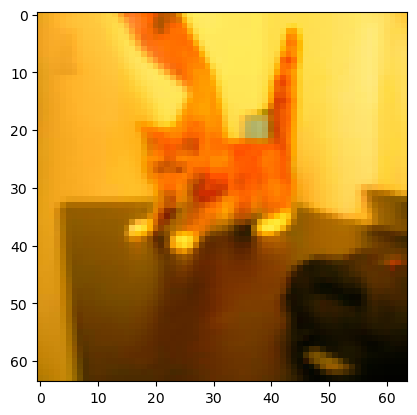

In [40]:
img = next(iter(train_dataset))
print(img[0].shape)
plt.imshow(img[0].permute(1,2,0)), img[1]

torch.Size([3, 64, 64])


(<matplotlib.image.AxesImage at 0x1c5f50d7730>, 0)

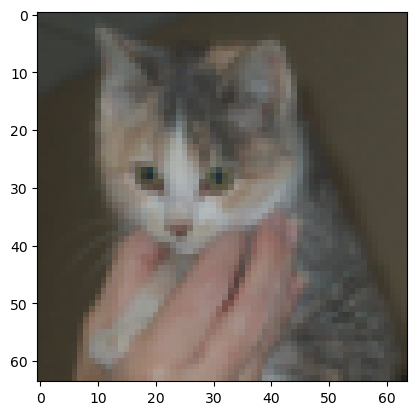

In [41]:
img = next(iter(test_dataset))
print(img[0].shape)
plt.imshow(img[0].permute(1,2,0)), img[1]

In [42]:
batch = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch)

len(train_dataloader), len(test_dataloader)

(625, 157)

In [75]:
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
# model

In [76]:
summary(model, input_size=[1,3,64,64])

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 1000]                 --
├─Conv2d: 1-1                            [1, 64, 32, 32]           9,408
├─BatchNorm2d: 1-2                       [1, 64, 32, 32]           128
├─ReLU: 1-3                              [1, 64, 32, 32]           --
├─MaxPool2d: 1-4                         [1, 64, 16, 16]           --
├─Sequential: 1-5                        [1, 64, 16, 16]           --
│    └─BasicBlock: 2-1                   [1, 64, 16, 16]           --
│    │    └─Conv2d: 3-1                  [1, 64, 16, 16]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 16, 16]           128
│    │    └─ReLU: 3-3                    [1, 64, 16, 16]           --
│    │    └─Conv2d: 3-4                  [1, 64, 16, 16]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 16, 16]           128
│    │    └─ReLU: 3-6                    [1, 64, 16, 16]           --
│

In [77]:
in_features = model.fc.in_features
print(in_features)
for params in model.parameters():
    # print(params)
    params.requires_grad = False
model.fc = nn.Linear(in_features=in_features, out_features=1)
model

512


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [78]:
criteron = nn.BCEWithLogitsLoss()
# optimizer = torch.optim.SGD(params=model.parameters(), lr=1e-3)
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=.1)

In [79]:
epochs = 20
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# print(device)

def train_model(model: torch.nn.Module, epochs: int, train_dataloader: torch.utils.data.DataLoader, test_dataloader: torch.utils.data.DataLoader, criteron: torch.nn.Module, optimizer: torch.optim.Optimizer, lr_scheduler: torch.optim.Optimizer=None):
    model.to(device)
    for epoch in range(epochs):
        print('starting...')
        train_loss, test_loss, train_acc, test_acc = 0, 0, 0, 0
        model.train()
        for X, y in train_dataloader:
            X, y = X.to(device), y.type(torch.float32).to(device)
            logits = model(X).squeeze()
            preds = logits.sigmoid().round()
            loss = criteron(logits, y)
            train_loss += loss.item()
            train_acc += torch.eq(preds, y).sum().item() / len(y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if lr_scheduler is not None:
            lr_scheduler.step()
        train_acc = train_acc / len(train_dataloader)
        train_loss = train_loss / len(train_dataloader)
        # Testing
        model.eval()
        with torch.inference_mode():
            for X, y in test_dataloader:
                X, y = X.to(device), y.type(torch.float32).to(device)
                logits = model(X).squeeze()
                preds = logits.sigmoid().round().type(torch.int64)
                loss = criteron(logits, y)
                test_loss += loss.item()
                test_acc += torch.eq(preds, y).sum().item() / len(y)
            test_acc = test_acc / len(test_dataloader)
            test_loss = test_loss / len(test_dataloader)
        print(f'EPOCH {epoch+1} || train loss: {train_loss:.4f} | train acc: {int(train_acc * 100):.2f}% || test loss: {test_loss:.4f} | test acc: {int(test_acc * 100):.2f}%')

train_model(model, epochs, train_dataloader, test_dataloader, criteron, optimizer)

starting...
EPOCH 1 || train loss: 0.5758 | train acc: 68.00% || test loss: 0.4750 | test acc: 76.00%
starting...
EPOCH 2 || train loss: 0.5415 | train acc: 71.00% || test loss: 0.4814 | test acc: 76.00%
starting...
EPOCH 3 || train loss: 0.5407 | train acc: 72.00% || test loss: 0.4527 | test acc: 77.00%
starting...
EPOCH 4 || train loss: 0.5302 | train acc: 73.00% || test loss: 0.4556 | test acc: 77.00%
starting...
EPOCH 5 || train loss: 0.5364 | train acc: 72.00% || test loss: 0.4566 | test acc: 77.00%
starting...
EPOCH 6 || train loss: 0.5372 | train acc: 72.00% || test loss: 0.5028 | test acc: 75.00%
starting...
EPOCH 7 || train loss: 0.5396 | train acc: 72.00% || test loss: 0.4595 | test acc: 77.00%
starting...
EPOCH 8 || train loss: 0.5333 | train acc: 72.00% || test loss: 0.4541 | test acc: 78.00%
starting...
EPOCH 9 || train loss: 0.5396 | train acc: 72.00% || test loss: 0.4672 | test acc: 77.00%
starting...
EPOCH 10 || train loss: 0.5352 | train acc: 72.00% || test loss: 0.455